In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from datetime import date
from datetime import timedelta
from time import gmtime, strftime
import datetime
import time

In [2]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import bisect

In [3]:
def remove_outliers_multiple_cond(df_input,li_feats,threshold):
    # df_input: input dataframe
    # li_feats: list of feature to be considered
    # threshold: if number of feats in li_feats that tolerate the outlier boundaries is larger than thresdhold --> drop that rows
    for col in li_feats:
        q1 = df_input[col].quantile(0.25)
        q2 = df_input[col].quantile(0.5)
        q3 = df_input[col].quantile(0.75)
        df_input['ub_' + col] = q3 + 1.5*(q3-q1)
        df_input['lb_' + col] = q1 - 1.5*(q3-q1)
        
    output_li = []
    count = 1
    for col in li_feats:
        output_li.append('cond_' + str(count))
        df_input['cond_' + str(count)] = (df_input[col] <= df_input['ub_' + col]) & (df_input[col] >= df_input['lb_' + col])
        count += 1
        
    df_input['count_invalid_m'] = len(output_li) - df_input[output_li].sum(axis = 1)
    
    df_final = df_input[['customer_id','count_invalid_m'] + li_feats]
    df_final = df_final[df_final.count_invalid_m <= threshold][['customer_id'] + li_feats]
    
    return df_final

def deskew_data(df_input,li_feats,threshold):
    # df_input: input dataframe
    # li_feats: list of features to be considered
    # threshold: if the skewness of that column is higher than the threshold --> apply log transformation on that column
    li_feats_new = []
    for col in li_feats:
        skew_coef_before = abs(df_input[col].skew())
        if skew_coef_before >= threshold:
            df_input['log_' + col] = np.log(0.01 + df_input[col])
#             skew_coef_after = df_input['log_' + col].skew()
            li_feats_new.append('log_' + col)
        else:
            li_feats_new.append(col)
    return li_feats_new

def find_most_important_components_PCA(li_variance_ratio,cutoff_threshold):
    li_variance_ratio = np.array(li_variance_ratio)
    li_cumsum = li_variance_ratio.cumsum()
    idx = bisect.bisect_right(li_cumsum,cutoff_threshold)
    if li_cumsum[idx - 1] == cutoff_threshold:
        final_idx = idx - 1
        num_components = final_idx + 1
        return num_components
    else:
        final_idx = idx
        num_components = final_idx + 1
        return num_components
    
def find_optimal_K_for_KMeans(coordinates):
    start_idx = 1
    end_idx = 10
    
    mid_idx = (start_idx + end_idx) // 2
    while start_idx < end_idx:
        current_val = coordinates[mid_idx][1]
        last_val = coordinates[mid_idx-1][1]
        diff = (last_val - current_val) / last_val
        
        if diff < 0.1:
            end_idx = mid_idx - 1
        else:
            start_idx = mid_idx + 1
            
        mid_idx = (end_idx + start_idx) // 2
        
    return min(coordinates[start_idx - 1][0],8)

In [4]:
def cluster_by_DBSCAN(df_input,params_dict):
    epsilon = params_dict['epsilon']
    min_points = params_dict['min_points']
    li_feats = params_dict['li_feats']
    scaling_already = params_dict['scaling_already']
    
    df_feats = df_input[li_feats]
    if scaling_already == False:
        # scalng data according to StandardScaler
        scaler = StandardScaler()
        scaler.fit(df_feats)
        
        X_scale = scaler.transform(df_feats)
        df_feats_scale = pd.DataFrame(X_scale, columns = df_feats.columns)
    else:
        df_feats_scale = df_feats.copy()
        
    dbscan = DBSCAN(eps = epsilon, min_samples = min_points)
    dbscan.fit(df_feats_scale)
    df_tmp = pd.DataFrame(dbscan.labels_, columns = ['label'])
    
    df_output = pd.concat([df_input,df_tmp],axis = 1)
    return df_output

In [5]:
def cluster_by_KMeans(df_input,params_dict):
    num_clusters = params_dict['num_clusters']
    li_feats = params_dict['li_feats']
    scaling_already = params_dict['scaling_already']

    df_feats = df_input[li_feats]
    
    if scaling_already == False:
        # scaling data according to StandardScaler
        scaler = StandardScaler()
        scaler.fit(df_feats)
        
        X_scale = scaler.transform(df_feats)
        df_feats_scale = pd.DataFrame(X_scale, columns = df_feats.columns)
    else:
        df_feats_scale = df_feats.copy()
        
    km = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 2021)
    km.fit(df_feats_scale)
    df_tmp = pd.DataFrame(km.labels_, columns = ['label'])
    
    df_output = pd.concat([df_input,df_tmp], axis = 1)
    
    return (df_output,km.inertia_)

def show_elbow_chart(df_input,params_dict,elbow_chart = True):
#     num_clusters = params_dict['num_clusters']
    li_feats = params_dict['li_feats']
    scaling_already = params_dict['scaling_already']
    
    sse = []
    num_clusters = [i for i in range(1,12)]
    df_results = []
    
    for num_cluster in num_clusters:
        params_dict['num_clusters'] = num_cluster
        df_tmp,error = cluster_by_KMeans(df_input,params_dict)
        df_results.append(df_tmp)
        sse.append(error)
        
    if elbow_chart:
        plt.figure(figsize = (12,6))
        plt.plot(num_clusters,sse,marker = 'o')
        plt.title('Optimal Number of Clusters using Elbow Method')
        plt.xlabel('Number of Clusters')
        plt.xticks(num_clusters)
        plt.ylabel('Inertia')
        plt.show()
    
    return [df_results,list(zip(num_clusters,sse))]

def preprocess(df_input,li_feats):
    if 'num_orders' in li_feats:
        df_output = df_input[~df_input.num_orders.isna()]
    else:
        df_output = df_input.copy()
        
    df_output = df_output[li_feats]
    
    if 'sa_days_from_last_tx_date' in li_feats:
        df_output['sa_days_from_last_tx_date'] = df_output[['sa_days_from_last_tx_date','days_from_acquired']].min(axis = 1)
        
    if 'gt_days_from_last_tx_date' in li_feats:
        df_output['gt_days_from_last_tx_date'] = df_output[['gt_days_from_last_tx_date','days_from_acquired']].min(axis = 1)
        
    df_output.reset_index(drop = True, inplace = True)
    
    return df_output

def pca_transform(df_features,cutoff_threshold):
    # df_features: dataframe of the original features
    # cutoff_threshold: the ratio to determine number of main components to keep the variance in the original features
    
    li_feats = list(df_features.columns)
    pca = PCA(n_components = len(li_feats))
    X_new = pca.fit_transform(df_features)
    
    li_variance_ratio = pca.explained_variance_ratio_
    cutoff_threshold = 0.8
    
    num_most_important_components = find_most_important_components_PCA(li_variance_ratio,cutoff_threshold)
    
    # set the column names for X_new
    X_new = pd.DataFrame(
        X_new[:,0:num_most_important_components],
        columns = [f'PC_{i}' for i in range(1,num_most_important_components+1)]
    )
    
    return X_new,pca

def relabel_cluster(df_input,label_column):
    df_tmp = df_input.groupby(label_column)['customer_id'].count().reset_index(name = 'num_customers')
    df_tmp = df_tmp.sort_values(by = 'num_customers', ascending = False).reset_index(drop = True)
    df_tmp['new_label'] = df_tmp.index
    df_output = pd.merge(df_input,df_tmp, on = 'label')
    df_output['label'] = df_output['new_label']
    selected_cols = list(df_input.columns)
    return df_output[selected_cols]

In [6]:
def plot_clusters(df_input,num_clusters,column_names,filename = None):
    fig, ax = plt.subplots(figsize = (14,8))
    
    color_list = ['red','green','blue','yellow','pink','orange','purple','magenta']
    
    for i, color in enumerate(color_list[:num_clusters]):
        x = df_input[df_input.label == i][column_names[0]]
        y = df_input[df_input.label == i][column_names[1]]
        
        ax.scatter(x,y,c = color,label = 'Cluster' + str(i), s = 25)
        
    ax.legend()
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])
    if filename != None:
        plt.savefig(filename)
    plt.show()

In [7]:
df_features = pd.read_csv('df_features.csv')

In [8]:
df_features.head()

,customer_id,num_orders,num_products,num_categories,num_tx_dates,days_diff_from_start_tx_date,days_diff_from_last_tx_date,num_orders_per_tx_date,gmv,aov,median_order_value
0,5518,9,9,2,4,1215,1192,2.250000,516808.08,5.742312e+04,34560.00
1,6128,42,87,9,35,1215,572,1.200000,52224325.12,1.243436e+06,666746.94
2,6129,25,48,7,21,1209,1010,1.190476,26656128.62,1.066245e+06,519984.54
3,6130,9,32,5,8,1202,1146,1.125000,14236101.24,1.581789e+06,1239970.98
4,6131,15,37,5,15,1200,1064,1.000000,9705220.28,6.470147e+05,562287.00


In [9]:
list(df_features.columns)

['customer_id',
 'num_orders',
 'num_products',
 'num_categories',
 'num_tx_dates',
 'days_diff_from_start_tx_date',
 'days_diff_from_last_tx_date',
 'num_orders_per_tx_date',
 'gmv',
 'aov',
 'median_order_value']

In [10]:
#### De-skew data and remove outliers ####
# de-skew data
li_feats_to_deskew = [
    'num_orders',
 'num_products',
 'num_categories',
 'num_tx_dates',
 'days_diff_from_start_tx_date',
 'days_diff_from_last_tx_date',
 'num_orders_per_tx_date',
 'gmv',
 'aov',
 'median_order_value'
]

df_features_valid = df_features.copy()

threshold_to_deskew = 2
li_feats_new = deskew_data(df_features_valid,li_feats_to_deskew,threshold_to_deskew)
df_features_valid = df_features_valid[['customer_id'] + li_feats_new]

# # outlier removing
# threshold_to_drop = 6
# df_features_new = remove_outliers_multiple_cond(df_features_valid,li_feats_new,6)

# df_features_new.reset_index(drop = True, inplace = True)

In [11]:
# outlier removing
threshold_to_drop = 2
df_features_new = remove_outliers_multiple_cond(df_features_valid,li_feats_new,threshold_to_drop)

df_features_new.reset_index(drop = True, inplace = True)

In [12]:
df_features_new.shape

(866, 11)

#### Main proram

In [13]:
# choose features to do clustering
li_feats = list(df_features_new.columns)[1:].copy()

df_retailer = df_features_new[['customer_id']]
df_all_feats = df_features_new.drop(columns = ['customer_id'], axis = 1)
df_feats = df_all_feats[li_feats]

# perform scaling first
scaler = StandardScaler()
scaler.fit(df_feats)
X_scale = scaler.transform(df_feats)
df_feats_scale = pd.DataFrame(X_scale, columns = df_feats.columns)

#### PCA transform

In [14]:
cutoff_threshold = 0.8
df_feats_in_PCA, pca = pca_transform(df_feats_scale,cutoff_threshold)
df_after_PCA = pd.concat([df_retailer,df_feats_in_PCA], axis = 1)

In [15]:
df_after_PCA

,customer_id,PC_1,PC_2,PC_3
0,5518,1.004171,-4.916864,1.514167
1,6130,4.218977,-1.196378,0.176982
2,6131,4.329453,-2.075685,0.763139
3,6133,4.825310,-1.430040,0.810279
4,6134,3.775685,-2.399115,0.692467
...,...,...,...,...
861,7238,-1.223761,3.155217,3.553397
862,7239,-0.554491,5.527352,5.484389
863,7240,-3.635065,3.405190,11.421552
864,7241,-2.904151,4.795239,11.506995


In [16]:
threshold_to_drop = 1
li_feats_pca = list(df_after_PCA.columns[1:])
df_after_PCA = remove_outliers_multiple_cond(df_after_PCA,li_feats_pca,threshold_to_drop)

df_after_PCA.reset_index(drop = True, inplace = True)

#### DBSCAN

In [17]:
params_dict_dbscan = {
    'epsilon': .8,
    'min_points': 4,
    'li_feats': list(df_after_PCA.columns[1:]),
    'scaling_already': True
}

df_clustered_dbscan = cluster_by_DBSCAN(df_after_PCA,params_dict_dbscan)
df_clustered_dbscan = df_clustered_dbscan[df_clustered_dbscan.label != -1]

label_column = 'label'
df_clustered_dbscan = relabel_cluster(df_clustered_dbscan,label_column)

In [18]:
df_clustered_dbscan

,customer_id,PC_1,PC_2,PC_3,label
0,6130,4.218977,-1.196378,0.176982,0
1,6131,4.329453,-2.075685,0.763139,0
2,6133,4.825310,-1.430040,0.810279,0
3,6134,3.775685,-2.399115,0.692467,0
4,6139,4.778161,-1.829903,0.983827,0
...,...,...,...,...,...
844,6503,-4.124652,-3.773698,0.834540,1
845,7048,-3.978025,-3.278875,1.215664,1
846,7108,-3.156776,-2.749660,1.141458,1
847,7115,-3.608001,-2.664495,1.108364,1


In [19]:
df_clustered_dbscan.groupby('label')['customer_id'].count().reset_index()

,label,customer_id
0,0,840
1,1,9


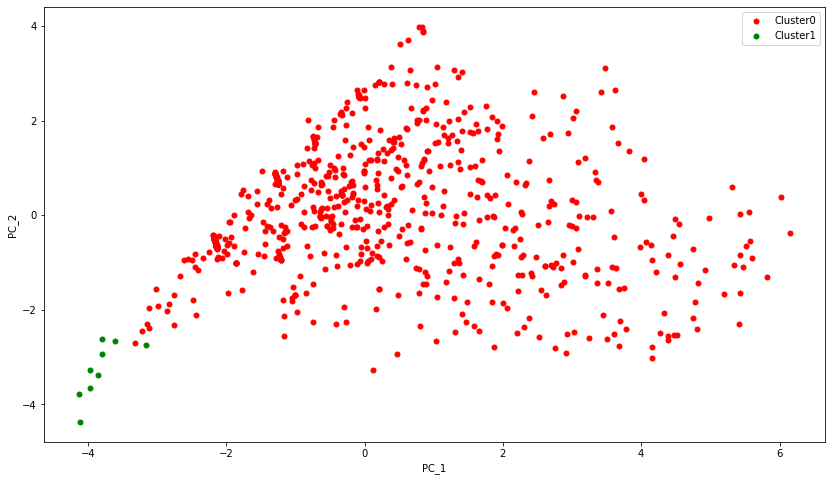

In [20]:
column_names = ['PC_1','PC_2']
num_clusters = df_clustered_dbscan['label'].max() + 1
# filename = 'fig_01_dbscan.png'
# plot_clusters(df_clustered_dbscan,num_clusters,column_names,filename)
plot_clusters(df_clustered_dbscan,num_clusters,column_names)

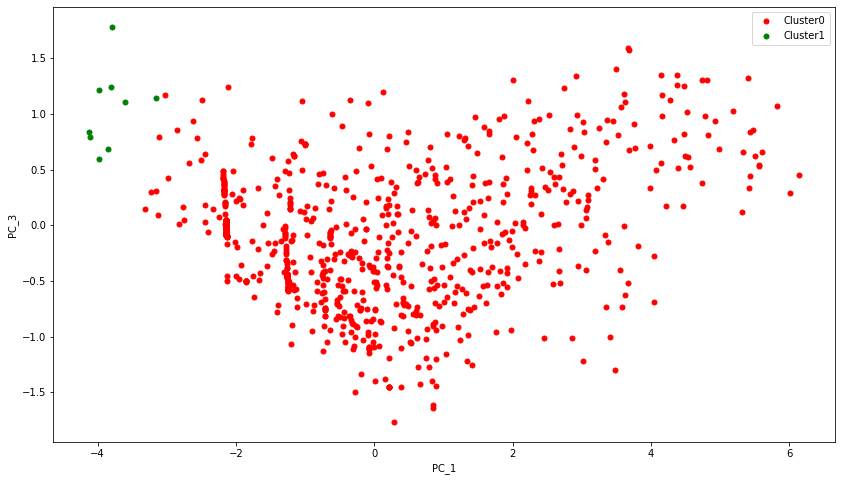

In [21]:
column_names = ['PC_1','PC_3']
num_clusters = df_clustered_dbscan['label'].max() + 1
# filename = 'fig_01_dbscan.png'
# plot_clusters(df_clustered_dbscan,num_clusters,column_names,filename)
plot_clusters(df_clustered_dbscan,num_clusters,column_names)

In [22]:
pca.explained_variance_ratio_

array([4.17357100e-01, 2.24018773e-01, 1.92432097e-01, 9.31394408e-02,
       5.85604505e-02, 1.05375839e-02, 3.51668352e-03, 4.37840139e-04,
       2.27442059e-08, 8.67052354e-09])

#### KMeans Automatically

In [23]:
#### Automatically choose optimal_K ####
params_dict = {
    'li_feats': list(df_after_PCA.columns[1:]),
    'scaling_already': True
}

# do shot show elbow_chart
elbow_chart = False

[df_tmp,coordinates] = show_elbow_chart(df_after_PCA,params_dict,elbow_chart)
optimal_K = find_optimal_K_for_KMeans(coordinates)

df_clustered_auto = df_tmp[optimal_K - 1]

label_column = 'label'
df_clustered_auto = relabel_cluster(df_clustered_auto,label_column)

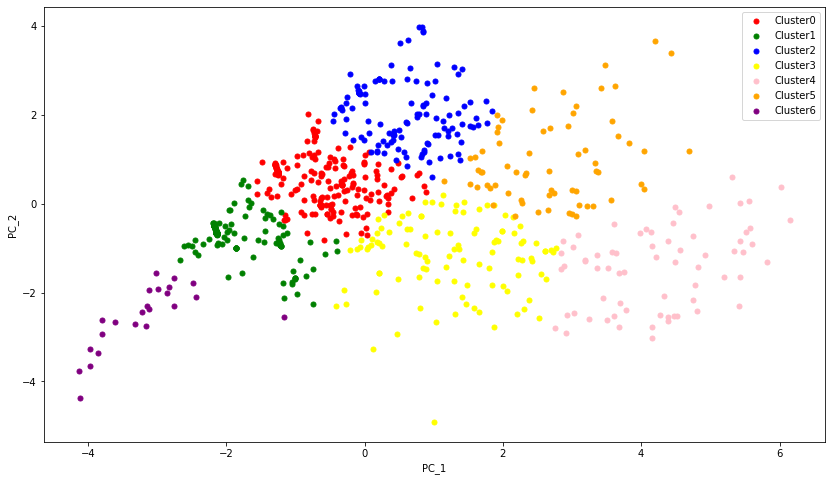

In [24]:
column_names = ['PC_1','PC_2']
num_clusters = df_clustered_auto['label'].max() + 1
# filename = 'fig_05_kmeans_auto.png'
# plot_clusters(df_clustered_auto,num_clusters,column_names,filename)
plot_clusters(df_clustered_auto,num_clusters,column_names)

In [25]:
# Manually choose number of cluster 
num_cluster = 4
params_dict = {
    'li_feats': list(df_after_PCA.columns[1:]),
    'scaling_already': True,
    'num_clusters': num_cluster
}

df_clustered_manual,_ = cluster_by_KMeans(df_after_PCA,params_dict)

label_column = 'label'
df_clustered_manual = relabel_cluster(df_clustered_manual,label_column)

In [26]:
# df_clustered_manual = df_clustered_manual[df_clustered_manual.label != 4]

In [27]:
df_clustered_manual.groupby('label')['customer_id'].count().reset_index()

,label,customer_id
0,0,280
1,1,256
2,2,162
3,3,156


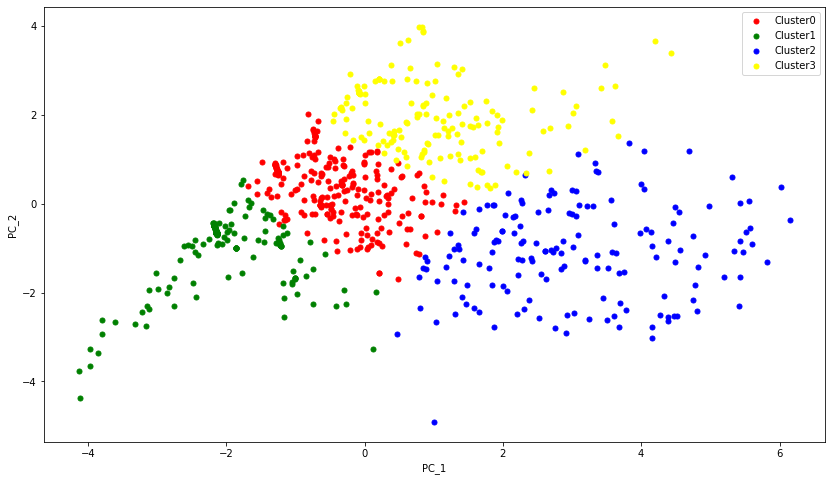

In [28]:
column_names = ['PC_1','PC_2']
num_clusters = df_clustered_manual['label'].max() + 1
# filename = 'fig_03_kmeans_manually.png'
# plot_clusters(df_clustered_manual,num_clusters,column_names,filename)
plot_clusters(df_clustered_manual,num_clusters,column_names)

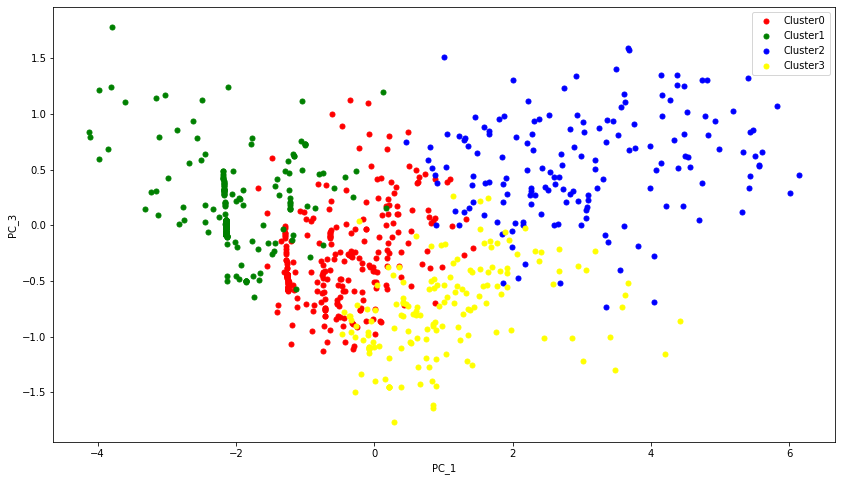

In [29]:
column_names = ['PC_1','PC_3']
num_clusters = df_clustered_manual['label'].max() + 1
# filename = 'fig_03_kmeans_manually.png'
# plot_clusters(df_clustered_manual,num_clusters,column_names,filename)
plot_clusters(df_clustered_manual,num_clusters,column_names)

#### Cluster Analysis

In [30]:
pca.explained_variance_ratio_

array([4.17357100e-01, 2.24018773e-01, 1.92432097e-01, 9.31394408e-02,
       5.85604505e-02, 1.05375839e-02, 3.51668352e-03, 4.37840139e-04,
       2.27442059e-08, 8.67052354e-09])

In [31]:
feature_importance = abs(pca.components_)

In [32]:
pca_nth_component = 1
my_list = list(zip(li_feats_new,feature_importance[pca_nth_component-1]))
sorted(my_list, key = lambda v: v[1], reverse = True)

[('log_gmv', 0.42966644817888394),
 ('log_num_orders', 0.4168715327830934),
 ('log_num_tx_dates', 0.4153910791059961),
 ('log_num_products', 0.39852509275536907),
 ('num_categories', 0.3965140060463073),
 ('log_aov', 0.28236200237890025),
 ('log_median_order_value', 0.22858055296567453),
 ('log_num_orders_per_tx_date', 0.1138585379341661),
 ('log_days_diff_from_start_tx_date', 0.08505884548190175),
 ('log_days_diff_from_last_tx_date', 0.028868146464074936)]

In [33]:
pca_nth_component = 2
my_list = list(zip(li_feats_new,feature_importance[pca_nth_component-1]))
sorted(my_list, key = lambda v: v[1], reverse = True)

[('log_median_order_value', 0.5430824468383919),
 ('log_aov', 0.50882908624382),
 ('log_days_diff_from_start_tx_date', 0.29357181936079396),
 ('log_gmv', 0.2864243426485657),
 ('log_days_diff_from_last_tx_date', 0.26532289955669036),
 ('log_num_orders', 0.2364435469531282),
 ('log_num_tx_dates', 0.21442249335498417),
 ('log_num_products', 0.20098328112341235),
 ('log_num_orders_per_tx_date', 0.18630341684705756),
 ('num_categories', 0.17478289316263046)]

In [34]:
pca_nth_component = 3
my_list = list(zip(li_feats_new,feature_importance[pca_nth_component-1]))
sorted(my_list, key = lambda v: v[1], reverse = True)

[('log_days_diff_from_last_tx_date', 0.6589076058274511),
 ('log_days_diff_from_start_tx_date', 0.6340373514794632),
 ('log_median_order_value', 0.21615273471278726),
 ('log_aov', 0.19258687066583696),
 ('log_num_orders', 0.1498415428979042),
 ('log_num_tx_dates', 0.13630981986688814),
 ('log_num_orders_per_tx_date', 0.11562731922896066),
 ('num_categories', 0.10369509874952276),
 ('log_num_products', 0.0932194011903394),
 ('log_gmv', 0.07861700992637899)]

In [35]:
df_final = pd.merge(df_features_new,df_clustered_manual[['customer_id','label']], on = 'customer_id')

In [36]:
df_final.head()

,customer_id,log_num_orders,log_num_products,num_categories,log_num_tx_dates,log_days_diff_from_start_tx_date,log_days_diff_from_last_tx_date,log_num_orders_per_tx_date,log_gmv,log_aov,log_median_order_value,label
0,5518,2.198335,2.198335,2,1.388791,7.102508,7.083396,0.815365,13.155427,10.958202,10.450453,2
1,6130,2.198335,3.466048,5,2.080691,7.091750,7.044042,0.126633,16.471292,14.274067,14.030599,2
2,6131,2.708717,3.611188,5,2.708717,7.090085,6.969800,0.009950,16.088174,13.380124,13.239768,2
3,6133,2.398804,3.637849,6,2.198335,7.090918,6.878337,0.208819,16.905699,14.507804,13.528130,2
4,6134,2.398804,3.332562,5,2.198335,7.085910,7.044042,0.208819,15.676009,13.278113,12.896436,2


                                  log_num_orders  log_num_products  \
log_num_orders                          1.000000          0.687548   
log_num_products                        0.687548          1.000000   
num_categories                          0.664889          0.891666   
log_num_tx_dates                        0.990804          0.688526   
log_days_diff_from_start_tx_date        0.385196          0.423470   
log_days_diff_from_last_tx_date        -0.199726         -0.018517   
log_num_orders_per_tx_date              0.268354          0.132485   
log_gmv                                 0.632108          0.498928   
log_aov                                 0.190963          0.212849   
log_median_order_value                  0.061815          0.144614   

                                  num_categories  log_num_tx_dates  \
log_num_orders                          0.664889          0.990804   
log_num_products                        0.891666          0.688526   
num_categories     

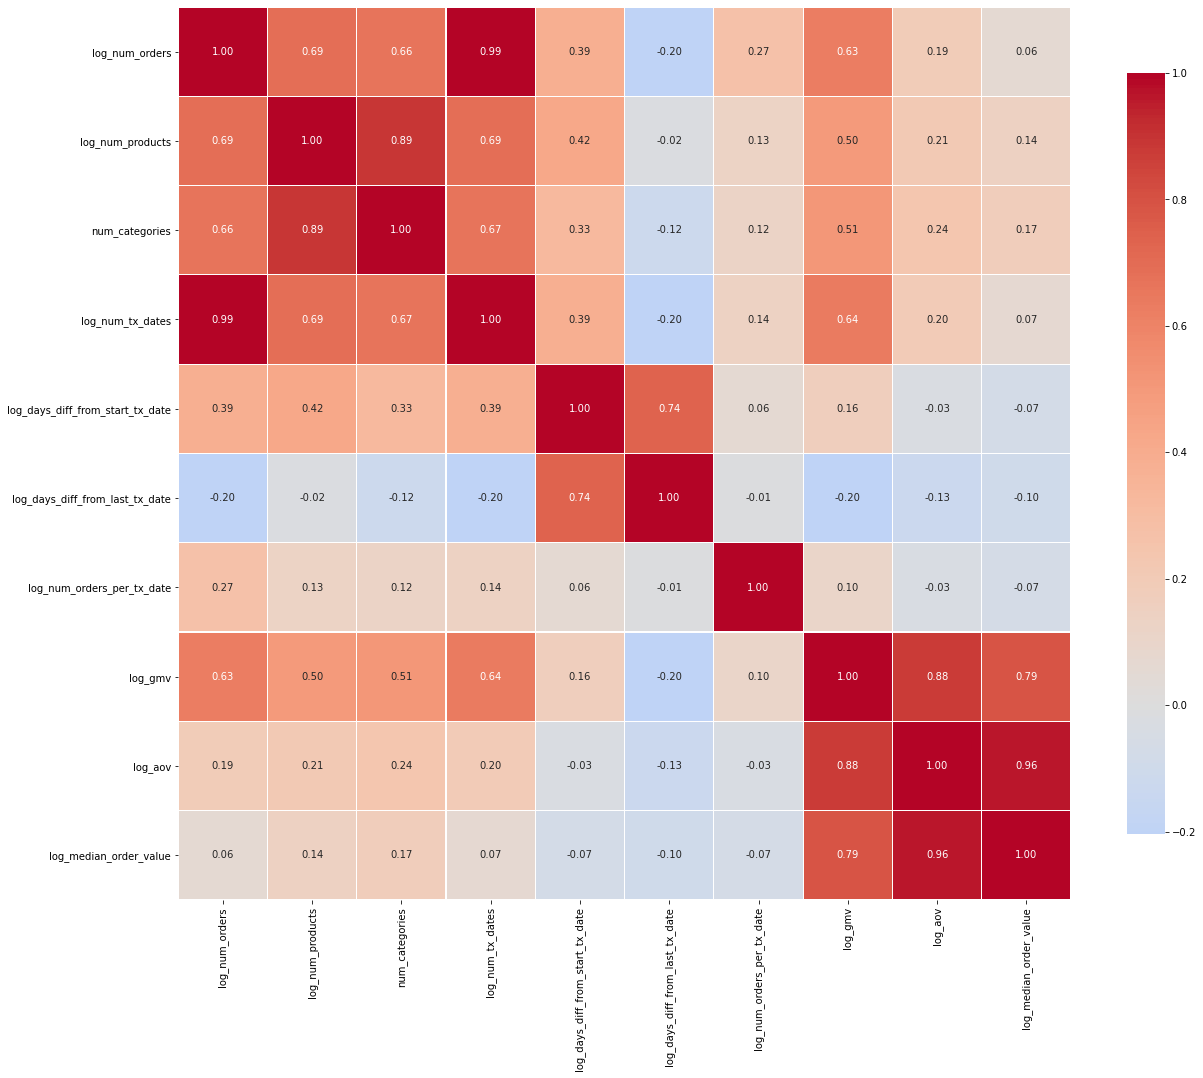

In [37]:
import seaborn as sns

def correlation_heatmap(train,filename = None):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize = (20,20))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f', cmap = 'coolwarm',
               square = True, linewidths = .2, annot = True, cbar_kws = {'shrink': .7})
    print(correlations)
    
    if filename != None:
        plt.savefig(filename)
    plt.show()
    
train = df_final.drop(columns = ['customer_id','label'], axis = 1)
filename = 'fig_07_heatmap.png'
correlation_heatmap(train,filename)

In [38]:
train

,log_num_orders,log_num_products,num_categories,log_num_tx_dates,log_days_diff_from_start_tx_date,log_days_diff_from_last_tx_date,log_num_orders_per_tx_date,log_gmv,log_aov,log_median_order_value
0,2.198335,2.198335,2,1.388791,7.102508,7.083396,0.815365,13.155427,10.958202,10.450453
1,2.198335,3.466048,5,2.080691,7.091750,7.044042,0.126633,16.471292,14.274067,14.030599
2,2.708717,3.611188,5,2.708717,7.090085,6.969800,0.009950,16.088174,13.380124,13.239768
3,2.398804,3.637849,6,2.198335,7.090918,6.878337,0.208819,16.905699,14.507804,13.528130
4,2.398804,3.332562,5,2.198335,7.085910,7.044042,0.208819,15.676009,13.278113,12.896436
...,...,...,...,...,...,...,...,...,...,...
849,0.009950,0.698135,1,0.009950,6.714183,6.714183,0.009950,12.305918,12.305918,12.305918
850,0.009950,0.009950,1,0.009950,6.706875,6.706875,0.009950,14.603968,14.603968,14.603968
851,0.698135,0.009950,1,0.698135,6.705651,6.701973,0.009950,14.220976,13.527828,13.527828
852,0.009950,0.009950,1,0.009950,6.705651,6.705651,0.009950,15.501910,15.501910,15.501910


In [39]:
def get_uncorrelated_feats(df_input,ordered_list,threshold):
    correlations = df_input.corr()
#     li_col = list(correlations.columns)
    li_col = ordered_list
    
    li_tmp = []
#     threshold = 0.8
    for i1 in range(len(li_col)-1):
        v1 = li_col[i1]
        tmp = [v1]
        for i2 in range(i1+1,len(li_col)):
            v2 = li_col[i2]
            if correlations.loc[v1][v2] >= threshold:
                tmp.append(v2)
        li_tmp.append(tmp)

    for v in li_tmp:
        v1 = v[0]
        if len(v) > 1:
            for v2 in v[1:]:
                if v2 in li_col:
                    del li_col[li_col.index(v2)]
                    
    return li_col

In [40]:
threshold = 0.8

pca_nth_component = 1
my_list = list(zip(li_feats_new,feature_importance[pca_nth_component-1]))
li_final = sorted(my_list, key = lambda v: v[1], reverse = True)
li_final_01 = [v[0] for v in li_final]
li_uncorrelated_feats = get_uncorrelated_feats(train,li_final_01,threshold)

In [41]:
li_uncorrelated_feats

['log_gmv',
 'log_num_orders',
 'log_num_products',
 'log_num_orders_per_tx_date',
 'log_days_diff_from_start_tx_date',
 'log_days_diff_from_last_tx_date']

In [42]:
def plot_violin_graph(df_input,num_clusters,col_x_name,col_y_name,title,filename = None):
    fig, ax = plt.subplots(figsize = (10,6))
    
    color_list = ['red','green','blue','yellow','pink','orange','purple','magenta']
    sns.violinplot(x = col_x_name, y = col_y_name, data = df_input, palette = color_list[:num_clusters])
    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel(None)
    if filename != None:
        plt.savefig(filename)
    plt.show()

In [43]:
df_final.groupby('label')['customer_id'].count().reset_index()

,label,customer_id
0,0,280
1,1,256
2,2,162
3,3,156


In [44]:
df_final

,customer_id,log_num_orders,log_num_products,num_categories,log_num_tx_dates,log_days_diff_from_start_tx_date,log_days_diff_from_last_tx_date,log_num_orders_per_tx_date,log_gmv,log_aov,log_median_order_value,label
0,5518,2.198335,2.198335,2,1.388791,7.102508,7.083396,0.815365,13.155427,10.958202,10.450453,2
1,6130,2.198335,3.466048,5,2.080691,7.091750,7.044042,0.126633,16.471292,14.274067,14.030599,2
2,6131,2.708717,3.611188,5,2.708717,7.090085,6.969800,0.009950,16.088174,13.380124,13.239768,2
3,6133,2.398804,3.637849,6,2.198335,7.090918,6.878337,0.208819,16.905699,14.507804,13.528130,2
4,6134,2.398804,3.332562,5,2.198335,7.085910,7.044042,0.208819,15.676009,13.278113,12.896436,2
...,...,...,...,...,...,...,...,...,...,...,...,...
849,7214,0.009950,0.698135,1,0.009950,6.714183,6.714183,0.009950,12.305918,12.305918,12.305918,1
850,7216,0.009950,0.009950,1,0.009950,6.706875,6.706875,0.009950,14.603968,14.603968,14.603968,0
851,7217,0.698135,0.009950,1,0.698135,6.705651,6.701973,0.009950,14.220976,13.527828,13.527828,0
852,7219,0.009950,0.009950,1,0.009950,6.705651,6.705651,0.009950,15.501910,15.501910,15.501910,3


In [45]:
# df_final.shape

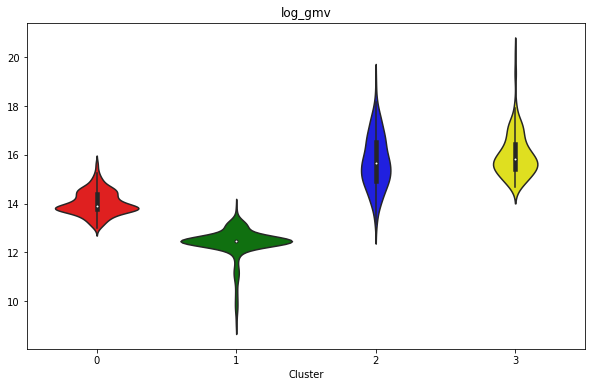

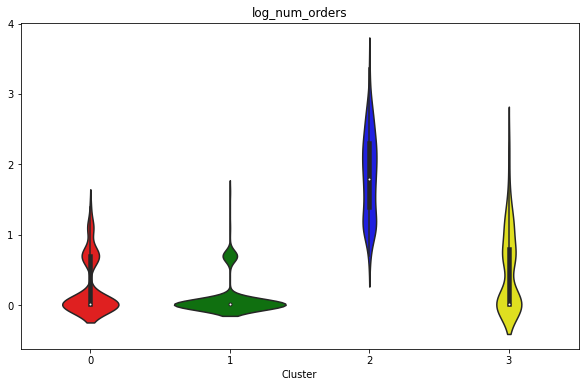

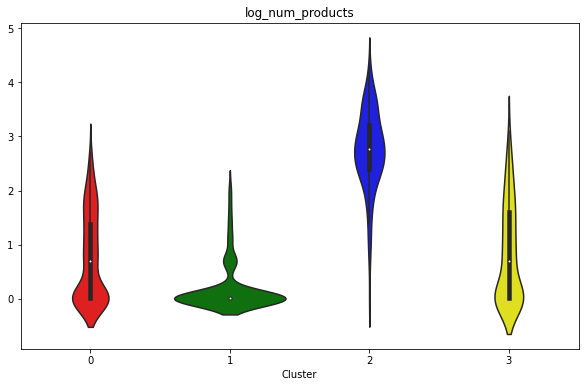

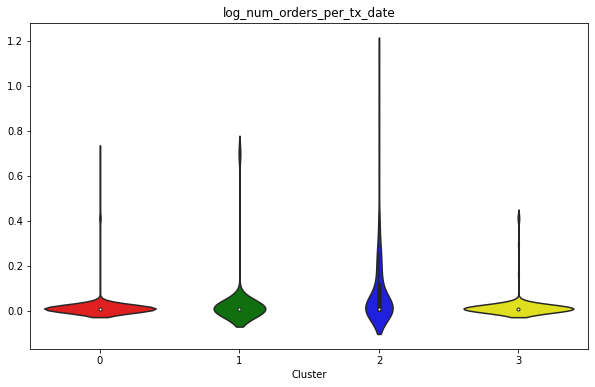

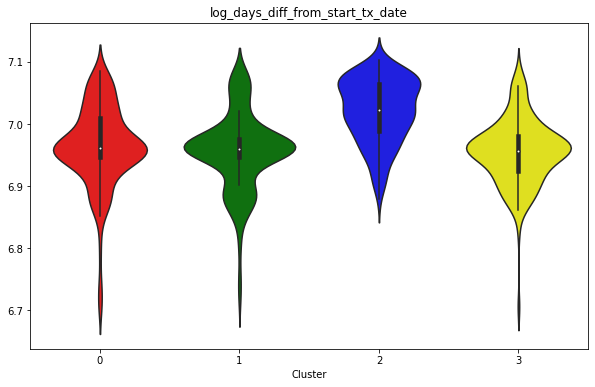

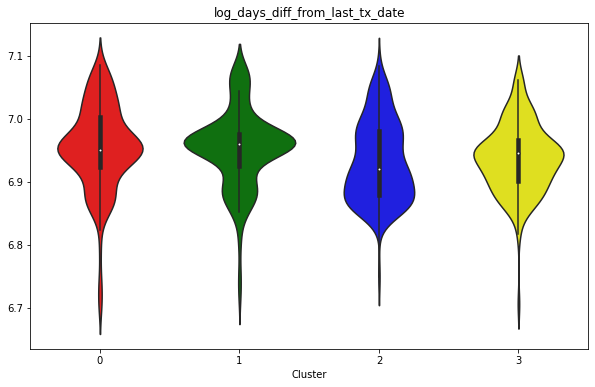

In [46]:
num_clusters = df_final['label'].max() + 1
for feat in li_uncorrelated_feats:
    col_x_name = 'label'
    col_y_name = feat
    title = feat
    plot_violin_graph(df_final,num_clusters,col_x_name,col_y_name,title)

In [47]:
# // xay dung thuat toan recommendation de de xuat san pham cho nguoi mua 

# // khi nguoi mua login vao trang web mua hang. Thuc an se tu de xuat len cac mat hang ma nguoi dung muon mua dua 
# tren so thich

In [48]:
df_label = df_final[['customer_id','label']]

In [49]:
df_label.to_csv('df_label.csv')

In [50]:
df_label.shape

(854, 2)